#### Template

*This Notebook is part of a Github Repository Template defining a Project File Structure. (See README.md)*

```.
├── config.yaml
├── data
│   └── README_data.md
├── environment.yaml
├── README.md
├── scripts
│   ├── clean.sh
│   ├── downsample.sh
│   ├── generate_reference.sh
│   ├── nb2py.sh
│   ├── README_scripts.md
│   └── run_ubs_seq.sh
├── src
│   └── README_IGV_WEB.md
└── workspace
    ├── README_workspace.md
    ├── ubs_basic.ipynb
    └── ubs_basic.py
```

In [296]:
home_path      = Path.cwd()/'..'
data_path      = home_path/'data'
workspace_path = home_path/'workspace'

# UBS-seq Pipeline
## Basic Workflow

**C. Bryan Daniels**

**2/1/2024**

## Project: UBS-seq Basic Pipeline

The purpose of this project is run a minimally viable UBS-seq pipline. For simplicity, it will run several single-end samples, mapping only to the genome. The core steps of the pipeline are:
- cut_apapter
- quality_control
- align2ref
- sort2ref
- dedupe
- filter->all_multi_unique
- call_peaks
- select_groups
- analysis_and_annotation

This pipeline is based upon the paper by [Qing Dai, etal](https://doi.org/10.1038/s41587-023-02034-w) and the UBS-seq pipeline developed by [Chang Ye](https://github.com/y9c/m5C-UBSseq)



## Setup

#### The logic for the Pipeline is defined through a series of Steps using dirs to save intermediate results
1. For each **Step** in the pipeline a dir will be created and labeled **Step** and will contain all files created by that **Step**
2. Within a **Step**, **in_path** and **out_path** will generically refer to the prior and current **Step**
3. Within each **Step**, the appropriate processes will occur. Generally this involves processing files from **in_path** and saving to **out_path**
4. **Abbreviated filenames** should not change through the pipeline (suffixes will reflect current file formats). The dir name should reflect the **Step**, not the filename.
6. The function **mkpath(step)** returns a path for a dir **Step**. It will create a dir if need be, but not overwrite an existing dir
8. The function **fname(path,sample,suffix)** returns a file name without actually creating the file

#### Convert Notebook to Script to Execute from the Command Line

```
cd workplace/
juptyer nbconvert ubs_basic.ipynb --to script
ipython ubs_basic.py
```

#### Environment

In [297]:
import os, sys, subprocess
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from pathlib import Path
from IPython.display import display, HTML
from snakemake import load_configfile

In [298]:
def fname(path, base, sufix):
    'Return a path and suffix complete filename'
    return Path(path)/f"{base}.{sufix}"

def mkpath(path):
    'Return dir path name; creates (not over-writting) a new dir within the pwd. Also prints date/time executed'
    path = Path(path)
    if not os.path.exists(path): os.makedirs(path)
    date = ! date "+%H:%M:%S_%m-%d-%Y"
    print(f">>> {{{path}}} {date[0]}")
    return path

In [299]:
# Set Java Flag
os.environ['_JAVA_OPTIONS'] = '-Xmx8g'

In [300]:
# Number of cores                                                                                                                                                                                               
nc = get_ipython().getoutput('nproc')                                                                                                                                                                           
nc = int(nc[0])                                                                                                                                                                                                 
nc  

32

In [301]:
# Programs added to shell PATH
os.environ['PATH'] = f"{str(home_path)}:" + os.environ['PATH'] # home_path
os.environ['PATH'] = '/home/cdaniels/bin/homer:' + os.environ['PATH'] # homer
os.environ['PATH'] = '/home/cdaniels/bin/hisat-3n:' + os.environ['PATH'] # hisat-3n

#### Functions

In [302]:
def nlines(file):
    'Returns fast linecout (fast)'
    result = subprocess.run(['wc', '-l', file], stdout=subprocess.PIPE)
    n = int(result.stdout.split()[0])
    return n

In [303]:
def nseqs(bam_fastq):
    'Returns number of sequences in bam, sam, fasta or fastq file'
    n = !samtools view -c {bam_fastq}
    return int(n[0])

In [304]:
def samples_string(samples,path,suffix='bam'):
    'Returns a space delimited string of sample files'
    return " ".join([str(fname(path,sample,suffix)) for sample in samples])    

In [305]:
def make_table(ds1, ds2, ds1_name, ds2_name, y_label=None, xs_labels=None, table_label=None):
    'Makes a bar graph comparing two datasets and their corresponding names'
    assert(len(ds1)==len(ds2))
    n = np.arange(len(ds1))
    width = 0.35
    fig, ax = plt.subplots()
    rects1 = ax.bar(n - width/2, ds1, width, label=ds1_name)
    rects2 = ax.bar(n + width/2, ds2, width,label=ds2_name)
    ax.set_ylabel(y_label)
    ax.set_title(table_label)
    ax.set_xticks(n)
    ax.set_xticklabels(range(1,len(ds1)+1)) if xs_labels == None else ax.set_xticklabels(xs_labels)
    ax.legend()
    plt.show()

In [306]:
def make_histogram(ds, ds_name, table_label=None, y_label="Frequency", density=True):
    'Makes a histogram for a dataset and its name'
    fig, ax = plt.subplots()
    ax.hist(ds, density=density)
    ax.set_ylabel(y_label)
    ax.set_xlabel(ds_name)
    if table_label is not None:
        ax.set_title(table_label)
    plt.show()

#### Define `references/`

Use `config.yaml` to configure `references/`, but not samples in `data/`

In [307]:
config = load_configfile("../config.yaml")

In [308]:
genome_fa  = home_path/config['reference']['genome']['fa'].removeprefix('~/')
genome_idx = home_path/config['reference']['genome']['hisat3n'].removeprefix('~/')
print(genome_fa)
print(genome_idx)

/home/cdaniels/uofc_data/ubs_seq/UBS-seq_basic/workspace/../reference/genome/Homo_sapiens.GRCh38.genome.fa
/home/cdaniels/uofc_data/ubs_seq/UBS-seq_basic/workspace/../reference/index/hisat3n/Homo_sapiens.GRCh38.genome/Homo_sapiens.GRCh38.genome


In [309]:
#genome_fa = ref_path/'genome/Homo_sapiens.GRCh38.genome.fa'
#genome_idx = ref_path/'index/hist3n/Homo_sapiens.GRCh38.genome'

## Step: select_samples

#### Define sample names and link to sample files

In [13]:
out_path = mkpath('samples')

>>> {samples} 21:30:34_02-24-2024


Define short names for treated samples and control samples

In [14]:
treated = ["t1","t2","t3"] # Edit
control = [] # Edit
samples = treated + control
print(treated, control, samples)

['t1', 't2', 't3'] [] ['t1', 't2', 't3']


Sample files

In [15]:
samples_fn = [data_path/'test0_R1.fq.gz', data_path/'test1_R1.fq.gz', data_path/'test2_R1.fq.gz']

In [17]:
s2fn = {name: fname for (name,fname) in zip(samples,samples_fn)};
s2fn

{'t1': PosixPath('/home/cdaniels/uofc_data/ubs_seq/UBS-seq_basic/workspace/../data/test0_R1.fq.gz'),
 't2': PosixPath('/home/cdaniels/uofc_data/ubs_seq/UBS-seq_basic/workspace/../data/test1_R1.fq.gz'),
 't3': PosixPath('/home/cdaniels/uofc_data/ubs_seq/UBS-seq_basic/workspace/../data/test2_R1.fq.gz')}

Symbolically link short names with sample files

In [18]:
for (s,fn) in s2fn.items():
    ! ln -s {data_path/fn} {fname(out_path,s,"fq.gz")}

ln: failed to create symbolic link 'samples/t1.fq.gz': File exists
ln: failed to create symbolic link 'samples/t2.fq.gz': File exists
ln: failed to create symbolic link 'samples/t3.fq.gz': File exists


Check that the files look correct

In [19]:
!ls -lLh {out_path}

total 13G
-rw-rw-r-- 1 cdaniels cdaniels 3.4G Feb  5 13:10 t1.fq.gz
-rw-rw-r-- 1 cdaniels cdaniels 4.6G Feb  5 13:15 t2.fq.gz
-rw-rw-r-- 1 cdaniels cdaniels 4.4G Feb  5 13:15 t3.fq.gz


How many sequence reads do we have per Sample

In [ ]:
# Total Reads per Samples

#files = [fname(out_path,sample, "fq.gz") for sample in samples]
#for f in files:
#    ns = nseqs(f)
#    print(f"{f}: {ns:,}")

## Step: fastqc_pre

#### Pre Trimming Quality Control

In [ ]:
in_path = mkpath("samples")
out_path = mkpath("fastqc_pre")

#### fastqc

In [ ]:
#! fastqc --help

##### paramaters:
- -o output dir

In [ ]:
for sample in samples:
    ! fastqc {fname(in_path,sample,"fq.gz")} -o {out_path} 2> /dev/null

In [ ]:
! ls {out_path}

## Step: trim

#### Trim the adapter and downstream sequence as well as trimmng lower quality downstream sequence

In [20]:
in_path = mkpath("samples")
out_path = mkpath("trim")

>>> {samples} 21:36:15_02-24-2024
>>> {trim} 21:36:15_02-24-2024


In [21]:
adapter =  "AGATCGGAAGAGCACACGTCT"
barcode3 = "ATCACG"

In [22]:
!ls {in_path}

t1.fq.gz  t2.fq.gz  t3.fq.gz


#### cutadapt

In [ ]:
#! cutadapt --help

```
cutadapt -j {threads} 
            -n 2 
            -a "{params.barcode3}{params.adapter3};e=0.15;o=6;anywhere;" 
            --untrimmed-output={output.fastq_untrimmed} 
            -o - {input} 2>{output.report1} | 
cutadapt -j {threads} 
            -u 5 -u -5 
            --rename='{{id}}_{{cut_prefix}}{{cut_suffix}} {{comment}}' 
            --max-n=0 
            -q 15 
            --nextseq-trim=15 
            -m 20 
            --too-short-output={output.fastq_tooshort} 
            -o {output.fastq_cut} - >{output.report2}
```

https://cutadapt.readthedocs.io/en/stable/guide.html

##### paramaters:
- -j 0, Number of CPU. Use 0 to autodetect
- --nextseq-trim=15, is used to trim these low-quality tails of 'G's by introducing a variable quality threshold
- --action=trim, trim adapter and downstream sequence
- -a '{barcode3}{adapter};e=0.15;o=6;anywhere;', 
- -n 2, Remove up to COUNT adapters from each read. Default: 1
- -u 5 -u -5, Remove LEN bases from each read. If positve, from beginning. If negative, from end
- --max-n=0, Discard reads with more than COUNT 'N' bases (here any)
- -q 15, Trim low-quality bases from 5' end of eachread before adapter removal.
- -m 20, Discard reads shorter than LEN
- --rename='{{id}}_{{cut_prefix}}{{cut_suffix}} {{comment}}', rename comment of fastq record
- --too-short-output={fname(out_path,sample,"fastq_tooshort")},
- -o {fname(out_path,sample,"fq.gz")}, output file
{fname(in_path,sample,"fq.gz")}, input file

**NOTE:** Added `--length 30` to cutoff reads where C begin to become more common. Not in original code

In [ ]:
for sample in samples:
    !cutadapt -j 0 --nextseq-trim=15 --action=trim -a '{barcode3}{adapter};e=0.15;o=6;anywhere;'\
            -n 2 -u 5 -u -5 --max-n=0 -q 15 -m 20 -l 80\
            --length 30 \
            --rename='{{id}}_{{cut_prefix}}{{cut_suffix}} {{comment}}'\
            --too-short-output={fname(out_path,sample,"fastq_tooshort")} \
            -o {fname(out_path,sample,"fq.gz")}  \
            {fname(in_path,sample,"fq.gz")} > {fname(out_path,sample,"log")}

#### Analysis

Take a look at a FASTQ file

In [23]:
in_fn  = fname(in_path,treated[0],'fq.gz')
out_fn = fname(out_path,treated[0],'fq.gz')
out_fn

PosixPath('trim/t1.fq.gz')

In [24]:
! zcat {in_fn}|head -16

@SRR23538290.1 1 length=121
GTGTGAGGTTTAGAAATAATAGTAATAGATGTAGAATTTGGGAATGATATTACTACCATCACGAGATCGGAATAGCACACGTCTGAACTCCAGTCACCACTCAATCTCGTATGCCGTCTTC
+
FF,:FFFFFFFFF:FFFFFFFFFFFFFFFF,FFFFFFFFF,,F,FFFFFFFFFFFFFF:FFFFFFFFFFFFF:FF:FFFFFFFFFFFFFFFFFFFF:FFFFFFFFFFFFFFF,F:,FF:F,
@SRR23538290.2 2 length=121
CCTATTGTGGGTTTGGTTGGGTGAGTATGGTTAATGTAGGTAAAGATATATAATCACGAGATCGTAAGATCAAACGTCTGAACTCCAGTCACCACTCAATCTCGTATGCCGTCTTCTGATT
+
:FF,F,FFF:FFF::FFFFFFFFFFFFFF:FFFFFFFFFFFFFFFF:FFFF,FFFFF,FFFFFF:FF,F,:F,F,FFFFFFF:FF,F:FFFFFFFFFFFFFFFFF:F,,F:F,,F,:F,:F
@SRR23538290.3 3 length=121
ACTAGATTGAGTGTGTTTATTAAAAGTAGTTGATTATTTTTTAAAATAAGAAGAGGGTTTTGTTGGGAGACGGTTATCACGAGATCGGAAGAGCACACGTCTGAACTCCAGTCACCACTCA
+
FFF,:FFFFFFFFF:FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF:FFF,FFFFFFFFF:FFFFFFFFF:FFFFFFF:FF,FFFFFFFFFFFF,FFFFFFFFFFF,FFFFFFFFF:
@SRR23538290.4 4 length=121
TCGAAAGGTGTTTATTGAATTTGGAGATTTTGAGGAGGAGGAAGAGGAAGATTCGTATCACGAGATCGGAAGAGCACACGTCTGAACTCCAGTCACCACTCAATCTCGTATTCCGTCTTCT
+
FFFFF:FFFFFFFFFFFFFFFF:FFF

In [25]:
def show_adapter(reads):
    for read in reads.split('\n'):
        read = read.replace(adapter, f'<span style="color: blue;">{barcode3}{adapter}</span>')
        display(HTML(read))

Look for adapter in untrimmed reads

In [26]:
reads = ! zcat {in_fn} | head -36  | seqtk seq -A |grep -v '>'
reads = ('\n').join(reads)
show_adapter(reads)

Verify that adapters and all downstream elements of reads have been trimmed

In [27]:
reads = !zcat {out_fn}| head -36  | seqtk seq -A |grep -v '>'
reads = ('\n').join(reads)
show_adapter(reads)

In [28]:
!ls {out_path}

t1.fastq_tooshort  t1.log	      t2.fq.gz	t3.fastq_tooshort  t3.log
t1.fq.gz	   t2.fastq_tooshort  t2.log	t3.fq.gz


What did `--rename='{{id}}_{{cut_prefix}}{{cut_suffix}} {{comment}}'` do?

It appears to has included in the fastq header, an id comprised of the first and last 5 nt cut by `-u 5` and `-u -5`

In [29]:
! zcat {in_fn}|head -2  

@SRR23538290.1 1 length=121
GTGTGAGGTTTAGAAATAATAGTAATAGATGTAGAATTTGGGAATGATATTACTACCATCACGAGATCGGAATAGCACACGTCTGAACTCCAGTCACCACTCAATCTCGTATGCCGTCTTC

gzip: stdout: Broken pipe


In [30]:
!zcat {out_fn}| head -2 

@SRR23538290.1_GTGTGTCTTC 1 length=121
AGGTTTAGAAATAATAGTAATAGATGTAGA

gzip: stdout: Broken pipe


Too slow for large files. Commented out.

In [ ]:
#files = [fname(in_path,sample, "fq.gz") for sample in samples]
#res = []
#for f in files:
#    n = !seqtk seq -A {f}|grep -v '>'|wc -c
#    res.append(int(n[0]))
#ins = res
#ins

In [ ]:
#files = [fname(out_path,sample, "fq.gz") for sample in samples]
#res = []
#for f in files:
#    n = !seqtk seq -A {f}|grep -v '>'|wc -c
#    res.append(int(n[0]))
#outs = res
#outs

In [ ]:
#make_table(ins, outs, "Origs", "Trimmed", "Sum of Total Read Lengths", samples, "Sum of Total Reads Per Sample")

In [ ]:
#reads = !xargs zcat {out_path}/*.gz | seqtk seq -A  |grep -v ">" 
#ds = [len(read) for read in reads]
#make_histogram(ds, "Read Length", "Trimmed Reads")

## Step: fastqc_post

#### Post Trimming Quality Control

In [31]:
in_path = mkpath("trim")
out_path = mkpath("fastqc_post")

>>> {trim} 21:37:28_02-24-2024
>>> {fastqc_post} 21:37:28_02-24-2024


In [32]:
for sample in samples:
    ! fastqc {fname(in_path,sample,"fq.gz")} -o {out_path} 2> /dev/null

application/gzip
Analysis complete for t1.fq.gz
application/gzip
Analysis complete for t2.fq.gz
application/gzip
Analysis complete for t3.fq.gz


#### Consolidate fastqc Reports

In [ ]:
!multiqc -f -fp -m fastqc -n multiqc -o {out_path} {out_path}

In [ ]:
! ls {out_path}

## Step: Hisat3n_align

#### Align Samples to Genome with Hisat-3n

In [ ]:
in_path = mkpath("trim")
out_path = mkpath("hisat3n_align")

#### hisat-3n

http://daehwankimlab.github.io/hisat2/hisat-3n/

In [ ]:
#! hisat-3n --help

```
hisat3n --index {params.index}
        -p {threads}
        --summary-file {output.summary}
        --new-summary
        -q
        -U {input}
        --directional-mapping
        --base-change C,T
        --pen-noncansplice 20
        --mp 4,1
        --un {output.fq}
        -S {output.sam}
```

##### paramaters:
- --index {params.index}, Index filename prefix (minus trailing .X.ht2) 
- -p {nc}, number of threads
- --summary-file, print alignment summary to this file.
- --new-summary, print alignment summary in a new style, which is more machine-friendly.
- -q, query input files are FASTQ .fq/.fastq (default)
- -U {input}, 
- --directional-mapping, make directional mapping, please use this option only if your reads are prepared with a strand specific library (off)
- --base-change C,T,  the converted nucleotide and converted to nucleotide (C,T)
- --pen-noncansplice 20, penalty for a non-canonical splice site (12)
- --mp 4,1,  max and min penalties for mismatch; lower qual = lower penalty <6,2>
- --un {output.fq}, write unpaired reads that didn't align to <path> 
- -S {output.sam}, File for SAM output (default: stdout)

In [ ]:
for sample in samples:
    !hisat-3n --index {genome_idx}\
        -p {nc}\
        --summary-file {fname(out_path,sample,"summary")}\
        --new-summary\
        -q\
        -U {fname(in_path,sample,'fq.gz')}\
        --directional-mapping\
        --base-change C,T\
        --pen-noncansplice 20\
        --mp 4,1\
        --un {fname(out_path,sample,'unmapped.fq')}\
        -S {fname(out_path,sample,'sam')}

#### Analysis

In [ ]:
!ls -lh {out_path}

In [ ]:
! cat {out_path}/t1.summary

In [ ]:
! head -8 {out_path}/t1.unmapped.fq

In [ ]:
! grep -v '@' {out_path}/t1.sam |head -1

## Step: Hisat3n_sort

#### Sort and Index Hisat3n Sam Files

In [ ]:
in_path = mkpath("hisat3n_align")
out_path = mkpath("hisat3n_sort")

#### samtools

http://www.htslib.org/doc/samtools.html

```
samtools view
    -@ {threads}
    -F4 -b {input} |
samtools sort
    -@ {threads}
    --write-index
    -m 4G
    -O BAM
    -o {output} -
```

##### paramaters:
```
samtools view, SAM<->BAM<->CRAM conversion
    -@ {nc}, number of threads 
    -F4 Filter out by Flag (-F 4 filters out unmapped reads)
    -b, output a bam file
    {input}  |
samtools sort, sort alignment file
    -@ {nc}, number of threads
    --write-index, index the output files
    -O BAM, output file format
    -o {output} -
```

In [ ]:
for sample in samples:
    ! samtools view -@ {nc} -F4 -b {fname(in_path, sample,'sam')}  | \
      samtools sort -@ {nc} --write-index -O BAM -o {fname(out_path,sample,'bam')} - 

#### Analysis

In [ ]:
! ls -lh {out_path}

## Step: Hisat3n_dedup

#### Remove Dulpicate Reads

In [33]:
in_path = mkpath("hisat3n_sort")
out_path = mkpath("hisat3n_dedup")

>>> {hisat3n_sort} 21:45:37_02-24-2024
>>> {hisat3n_dedup} 21:45:37_02-24-2024


#### umicollapse

https://github.com/Daniel-Liu-c0deb0t/UMICollapse

##### paramaters:
```
umicollapse bam, use a bam file
    --two-pass, use a separate two-pass algorithm for SAM/BAM deduplication.
    -i {input.bam}, indexed input bam file
    -o {output.bam}, output bam file
      > {output.log}
```

In [ ]:
for sample in samples:
    !umicollapse bam  \
    --two-pass \
    -i {fname(in_path,sample,'bam')} \
    -o {fname(out_path,sample,'bam')}\
    >  {fname(out_path,sample,'log')}

Index reads to use with IGV

In [41]:
for sample in samples:
    ! samtools index -@ {nc} -c {fname(out_path,sample,'bam')}

#### Analysis

In [42]:
! ls -lh {out_path}

total 8.9G
-rw-rw-r-- 1 cdaniels cdaniels 2.5G Feb  5 16:01 t1.bam
-rw-rw-r-- 1 cdaniels cdaniels 574K Feb 14 14:36 t1.bam.csi
-rw-rw-r-- 1 cdaniels cdaniels  461 Feb  5 16:01 t1.log
-rw-rw-r-- 1 cdaniels cdaniels 3.4G Feb  5 16:16 t2.bam
-rw-rw-r-- 1 cdaniels cdaniels 732K Feb 14 14:37 t2.bam.csi
-rw-rw-r-- 1 cdaniels cdaniels  462 Feb  5 16:16 t2.log
-rw-rw-r-- 1 cdaniels cdaniels 3.1G Feb  5 16:29 t3.bam
-rw-rw-r-- 1 cdaniels cdaniels 667K Feb 14 14:37 t3.bam.csi
-rw-rw-r-- 1 cdaniels cdaniels  462 Feb  5 16:29 t3.log


In [30]:
! cat {t_path}/t2.log

cat: {t_path}/t2.log: No such file or directory


## Step: Hisat3n_call

#### Call Converted bases

In [179]:
in_path = mkpath("hisat3n_dedup")
out_path = mkpath("hisat3n_call")

>>> {hisat3n_dedup} 10:28:26_02-25-2024
>>> {hisat3n_call} 10:28:26_02-25-2024


#### hisat-3n-table

http://daehwankimlab.github.io/hisat2/hisat-3n/

##### paramaters:
```
samtools view -e "rlen<100000" -h {input} |
hisat3ntable
    -p {threads}
    -m --alignments -
    --ref {params.fa}
    --output-name /dev/stdout
    --base-change C,T                      |
    bgzip -@ {threads} -c > {output}
```

In [ ]:
for sample in samples:
    !samtools view -e "rlen<100000" -h {fname(in_path,sample,'bam')} |\
    hisat-3n-table\
        -p {nc}\
        -m --alignments -\
        --ref {genome_fa}\
        --output-name /dev/stdout\
        --base-change C,T                          |\
    bgzip \
        -@ {nc} \
        -c > {fname(out_path,sample,'tsv.gz')}

#### Analysis

In [180]:
! ls -lh {out_path}

total 892M
-rw-rw-r-- 1 cdaniels cdaniels 290M Feb  5 16:47 t1.tsv.gz
-rw-rw-r-- 1 cdaniels cdaniels 313M Feb  5 17:10 t2.tsv.gz
-rw-rw-r-- 1 cdaniels cdaniels 290M Feb  5 17:31 t3.tsv.gz


In [181]:
! zcat {out_path}/t1.tsv.gz |head 

ref	pos	strand	convertedBaseQualities	convertedBaseCount	unconvertedBaseQualities	unconvertedBaseCount
1	10538	+	F	1		0
1	10539	+	F	1		0
1	10541	+	F	1		0
1	10542	+	F	1		0
1	10548	+	F	1		0
1	10553	+	F	1		0
1	10560	+	F	1		0
1	10563	+	F	1		0
1	10565	+	F	1		0

gzip: stdout: Broken pipe


There are 7 columns in the 3N-conversion-table:

1. `ref:` the chromosome name.
2. `pos:` 1-based position in ref.
3. `strand:` ‘+’ for forward strand. ‘-‘ for reverse strand.
4. `convertedBaseQualities:` the qualities for converted base in read-level measurement. Length of this string is equal to the number of converted Base in read-level measurement.
5. `convertedBaseCount:` number of distinct read positions where converted base in read-level measurements were found. this number should equal to the length of convertedBaseQualities.
6. `unconvertedBaseQualities:` the qualities for unconverted base in read-level measurement. Length of this string is equal to the number of unconverted Base in read-level measurement.
7. `unconvertedBaseCount:` number of distinct read positions where unconverted base in read-level measurements were found. this number should equal to the length of unconvertedBaseQualities.

Used IGV to look at reads in `t1.tsv.gz`:
- Needed to adjust preferences to show all reads
- Exactly the first 10,000 nt are all N
- The first read was aligned with a C at 10,358
- There were 9 C's, all in the positions shown above

Accordingly, this file appears to include all C's in the genome aligned to at least one read.

How many C's are in genome and what percent are covered by at least 1 read?

In [178]:
# Need speed up with parallel
C_total = !cat {genome_fa} | parallel --pipe grep -o 'C' | wc -l
C_total = int(C_total[0])
C_total

601243172

In [189]:
C_covered = []
for sample in samples:
    covered = !zcat {fname(out_path, sample, 'tsv.gz')} | wc -l
    covered = int(covered[0])
    C_covered.append(covered)
C_covered

[82592023, 102312523, 95042854]

In [210]:
[round(c/C_total,3) for c in C_covered]

[0.137, 0.17, 0.158]

Then for each sample, this is the ratio of C's covered by at least 1 read (called by `hisat3ntable`) to the total C's in genome

## Step: Filter_calls

#### Filter and Clean Up Calls

In [310]:
in_path = mkpath("hisat3n_call")
out_path = mkpath("filter_calls")

>>> {hisat3n_call} 14:21:21_02-25-2024
>>> {filter_calls} 14:21:21_02-25-2024


Filter and keep calls for which methlyated reads (Unconverted C's) exceed unmethylated reads (Converted T's): `unconvertedBaseCount` > `ConvertedBaseCount`

In [81]:
for sample in samples:
    df = pd.read_csv(fname(in_path, sample,'tsv.gz'), sep='\t', compression='gzip', low_memory=False, dtype={4: int, 6: int })
    df_f = df[df['unconvertedBaseCount'] > df['convertedBaseCount']]
    df_f.to_csv(fname(out_path,sample,'called.csv'), index=False)  # Set index=False 

Filter calls out calls for which field `ref` starts with 'K' or 'G', which are not artifacts associated with scafolding and assembly and are not located on chr 1-22, X, Y or MT

In [82]:
for sample in samples:
    ! grep -v '^[G|K]' {fname(out_path, sample,'called.csv')} > {fname(out_path, sample, 'tmp.csv')}
    ! mv {fname(out_path, sample, 'tmp.csv')} {fname(out_path, sample,'called.csv')}

#### Analysis

In [311]:
!ls -lh {out_path}

total 46M
-rw-rw-r-- 1 cdaniels cdaniels 13M Feb 25 08:31 t1.called.csv
-rw-rw-r-- 1 cdaniels cdaniels 18M Feb 25 08:31 t2.called.csv
-rw-rw-r-- 1 cdaniels cdaniels 16M Feb 25 08:31 t3.called.csv


Make sure we removed artifacts

In [312]:
!tail -3 {fname(out_path,'t1','called.csv')}

Y,57213353,+,,0,F,1
Y,57214057,-,,0,F,1
Y,57216151,+,,0,F,1


##### Assumption: C will be considered methylated (5mC) iff methylated reads (Unconverted C's) exceed unmethylated reads (Converted T's)

In [313]:
C_me = []
for sample in samples:
    me = !cat {fname(out_path, sample, 'called.csv')} | wc -l
    me = int(me[0])
    C_me.append(me)
C_me

[607025, 893920, 790210]

The ratio of 5mC (as defined) to C's covered by at least 1 read is: 

In [314]:
[round(me/covered,3) for me, covered in zip(C_me, C_covered)]

[0.007, 0.009, 0.008]

The ratio of 5mC (as defined) to all C's in genmome is:

In [315]:
[round(me/C_total,4) for me in C_me]

[0.001, 0.0015, 0.0013]

What is the distribution of Unconverted C's by postion in each sample? (These distributions look similiar for all samples)

In [316]:
df = pd.read_csv(fname(out_path,'t2','called.csv'), low_memory=False)
ds = df['unconvertedBaseCount'].values
{v: n for v,n in zip(*np.unique(ds, return_counts=True))}

{1: 848584,
 2: 27685,
 3: 7045,
 4: 3124,
 5: 1818,
 6: 1167,
 7: 846,
 8: 594,
 9: 510,
 10: 397,
 11: 290,
 12: 253,
 13: 186,
 14: 152,
 15: 157,
 16: 124,
 17: 132,
 18: 94,
 19: 87,
 20: 70,
 21: 69,
 22: 53,
 23: 36,
 24: 38,
 25: 40,
 26: 31,
 27: 29,
 28: 24,
 29: 24,
 30: 25,
 31: 11,
 32: 15,
 33: 18,
 34: 9,
 35: 10,
 36: 9,
 37: 6,
 38: 5,
 39: 7,
 40: 7,
 41: 2,
 42: 4,
 44: 5,
 45: 3,
 46: 4,
 47: 2,
 48: 9,
 49: 2,
 50: 1,
 51: 2,
 52: 4,
 53: 6,
 54: 3,
 55: 3,
 56: 1,
 57: 7,
 58: 2,
 60: 2,
 61: 6,
 62: 2,
 67: 1,
 68: 4,
 69: 2,
 73: 1,
 75: 2,
 76: 5,
 77: 3,
 98: 2,
 101: 3,
 112: 1,
 115: 1,
 119: 1,
 120: 1,
 121: 1,
 123: 2,
 126: 1,
 127: 1,
 128: 1,
 129: 4,
 133: 1,
 136: 2,
 140: 1,
 149: 1,
 150: 1,
 156: 1,
 163: 3,
 167: 3,
 181: 1,
 216: 1,
 220: 1,
 227: 1,
 240: 1,
 296: 1,
 644: 1,
 839: 1,
 840: 1,
 841: 1,
 851: 1,
 853: 1,
 901: 1,
 905: 1,
 1061: 1,
 1287: 2,
 1450: 1}

In [317]:
!head {out_path}/t1.called.csv

ref,pos,strand,convertedBaseQualities,convertedBaseCount,unconvertedBaseQualities,unconvertedBaseCount
1,12520,+,,0,F,1
1,13199,+,,0,F,1
1,13225,-,,0,F,1
1,14124,+,,0,F,1
1,14125,+,,0,F,1
1,14128,+,,0,F,1
1,15260,+,,0,F,1
1,17711,+,,0,F,1
1,19228,-,,0,F,1


In [318]:
!wc -l {out_path}/t1.called.csv

607025 filter_calls/t1.called.csv


In [460]:
bin_size = 100000

df = pd.read_csv(fname(out_path,'t3','called.csv'), low_memory=False)

df_ref = df[df['ref'] == 'Y'].copy()
df_ref['bin'] = (df_ref['pos'] / bin_size).apply(np.floor)

bin_counts = df_ref.groupby('bin')['unconvertedBaseCount'].size()

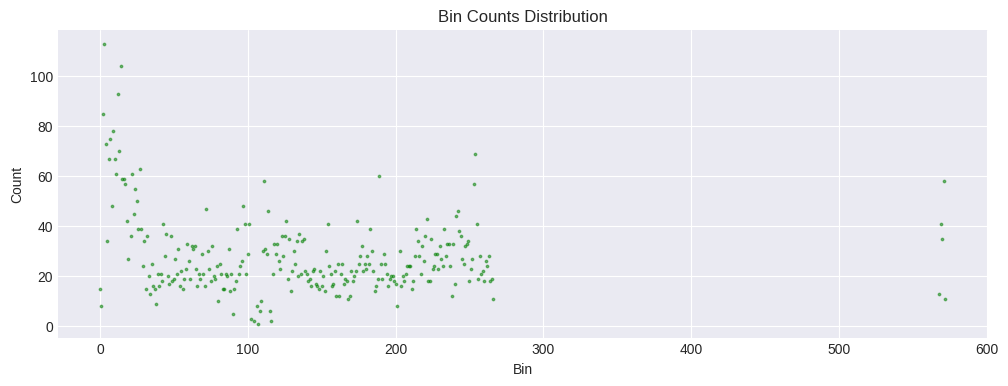

In [461]:
# Plotting
plt.style.use('seaborn-v0_8-darkgrid')  # Example style, replace with your preferred style
fig, ax = plt.subplots(figsize=(12, 4))

# Assuming bin_counts index is what you want on the x-axis and the values are what you want on the y-axis
ax.scatter(bin_counts.index, bin_counts.values, s=3, alpha=0.5, color='green')  # s controls the marker size, alpha controls transparency

ax.set_xlabel('Bin')  # Assuming 'Bin' is the appropriate label
ax.set_ylabel('Count')
ax.set_title('Bin Counts Distribution')

plt.show()